In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import random
from easydict import EasyDict as edict
from matplotlib import pyplot as plt
import torch, torch.nn as nn

from iterative_sir.toy_examples_utils.gan_fc_models import (Generator_fc, 
                           Discriminator_fc)

from iterative_sir.sampling_utils.distributions import (
                           GaussianMixture, 
                           IndependentNormal)

from iterative_sir.toy_examples_utils.params_25gaussians_wasserstein import (sigma,
                                random_seed,
                                train_dataset_size,
                                n_dim,
                                n_layers_d,
                                n_layers_g,
                                n_hid_d,
                                n_hid_g,
                                n_out,
                                device)


In [4]:
import seaborn as sns
sns.set_theme(style="ticks", palette="deep")

In [5]:
from pathlib import Path
figpath = Path('../figs')

In [6]:
import itertools

def prepare_2d_ring_data(batch_size=500,
                        sigma=0.01,
                        rad=2,
                        random_seed=42):
    dataset = []
    rad = 2
    for i in range(batch_size//8):
        for j in range(8):
            phi = 2 * np.pi * (j / 8.)
            x = rad * np.cos(phi)
            y = rad * np.sin(phi)
            point = np.random.randn(2)*sigma
            point[0] += x
            point[1] += y
            dataset.append(point)
    dataset = np.array(dataset, dtype=np.float32)

    means = np.array([
        [
            rad * np.cos(2 * np.pi * (j / 8.)), 
            rad * np.sin(2 * np.pi * (j / 8.))
        ] for j in range(8)])

    return dataset, means

In [7]:
from sklearn.preprocessing import StandardScaler

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

X_train, means = prepare_2d_ring_data(train_dataset_size,
                                         0.02,#sigma / 2., 
                                         random_seed)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)

In [8]:
G = Generator_fc(n_dim=256, #n_dim, 
                 n_layers=2, #n_layers_g,
                 n_hid=128, #n_hid_g,
                 n_out=2, #n_out,
                 non_linear=nn.ReLU(),
                 device=device)
D = Discriminator_fc(n_in=2, #n_dim, 
                     n_layers=2, #n_layers_d,
                     n_hid=128, #n_hid_d,
                     non_linear=nn.ReLU(),
                     device=device)

In [88]:
models_2d_path = Path(sorted(Path('../dump/2d_ring').glob('*'))[-1], 'models') #/models/models_100gaussians'

dics_path = sorted(Path(models_2d_path).glob('350_discriminator.pth'))[0]#[-6]
gen_path = sorted(Path(models_2d_path).glob('350_generator.pth'))[0]#[-6]

G.load_state_dict(torch.load(gen_path, map_location=device))
D.load_state_dict(torch.load(dics_path, map_location=device))

G = G.to(device)
D = D.to(device)
G.eval()
D.eval()
G.z_dim = G.n_dim

In [89]:
gen_path

PosixPath('../dump/2d_ring/2022_01_14-15_27_39_None/models/350_generator.pth')

In [90]:
n_dim = G.n_dim
n_out = 2
loc = torch.zeros(n_dim).to(G.device)
scale = torch.ones(n_dim).to(G.device)
normalize_to_0_1 = True 
log_prob = True

proposal_args = edict()
proposal_args.device = device
proposal_args.loc = loc
proposal_args.scale = scale
proposal = IndependentNormal(dim=n_dim, **proposal_args)

# target_gan = partial(gan_energy, 
#                      generator = G, 
#                      discriminator = D, 
#                      proposal = proposal,
#                      normalize_to_0_1 = normalize_to_0_1,
#                      log_prob = log_prob)

In [91]:
n_pts_ax = 100 #200
latent_grid = np.meshgrid(np.linspace(-3, 3, n_pts_ax), np.linspace(-3, 3, n_pts_ax))
real_grid = np.meshgrid(np.linspace(-2.2, 2.2, n_pts_ax), np.linspace(-2.2, 2.2, n_pts_ax))

In [109]:
#zs = np.stack(latent_grid, -1).reshape(-1, n_dim)
zs = np.random.rand(50000, n_dim) #n_pts_ax * n_pts_ax, n_dim)
xs_normalized = G(torch.from_numpy(zs).float()).detach().numpy()
xs = xs_normalized
#xs = scaler.inverse_transform(xs_normalized)
# dgz = D(torch.from_numpy(xs_normalized)).squeeze()

reals = np.stack(real_grid, -1).reshape(-1, n_out)
dgz_ = D(torch.from_numpy(scaler.transform(reals)).float()).squeeze()

#log_prob = proposal.log_prob(torch.from_numpy(zs)).squeeze()
#energy = (log_prob + dgz).detach().numpy()
# energy = -(dgz).detach().numpy()
# #energy = (log_prob).detach().numpy()
# energy_grid = energy.reshape(n_pts_ax, n_pts_ax)

In [110]:
import scipy.stats as stats

kde = stats.kde.gaussian_kde(xs.transpose(1, 0)) #, bw_method=50)
#log_probs = kde.logpdf(xs.transpose(1, 0))
log_probs = kde.logpdf(reals.transpose(1, 0))


In [111]:
log_probs

array([ -11068.07587802,  -12338.53378584,  -13707.43539022, ...,
       -173700.89731641, -179574.33861535, -185546.22361085])

In [121]:
energy = (log_probs + 10000 * dgz_.detach().numpy())
energy_grid = energy.reshape(n_pts_ax, n_pts_ax)

In [122]:
from  pathlib import Path
Path('../figs/2d_grid').mkdir(exist_ok=True)

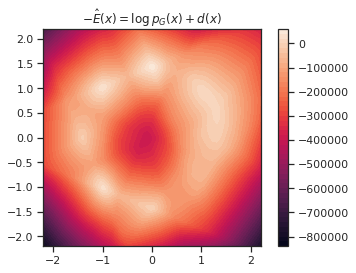

In [123]:
# xs_grid = xs.reshape(n_pts_ax, n_pts_ax, 2)
xs_grid = reals.reshape(n_pts_ax, n_pts_ax, 2)

fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.contourf(xs_grid[..., 0], xs_grid[..., 1], energy_grid, levels=50)
fig.colorbar(im)
ax.set_aspect('equal')
plt.title(r'$-\hat{E}(x) = \log p_G(x) + d(x)$')
plt.savefig(Path('../figs/2d_grid', 'minus_energy.png'))

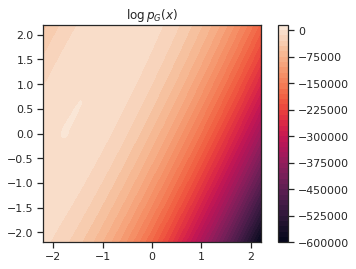

In [124]:
# xs_grid = xs.reshape(n_pts_ax, n_pts_ax, 2)
xs_grid = reals.reshape(n_pts_ax, n_pts_ax, 2)

fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.contourf(xs_grid[..., 0], xs_grid[..., 1], log_probs.reshape(n_pts_ax, n_pts_ax), levels=50)
fig.colorbar(im)
ax.set_aspect('equal')
plt.title(r'$\log p_G(x)$')
plt.savefig(Path('../figs/2d_grid', 'log_prob.png'))

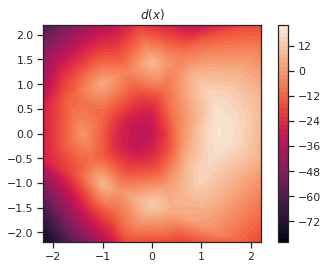

In [125]:
# xs_grid = xs.reshape(n_pts_ax, n_pts_ax, 2)
xs_grid = reals.reshape(n_pts_ax, n_pts_ax, 2)

fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.contourf(xs_grid[..., 0], xs_grid[..., 1], dgz_.detach().numpy().reshape(n_pts_ax, n_pts_ax), levels=50)
fig.colorbar(im)
ax.set_aspect('equal')
plt.title(r'$d(x)$')
plt.savefig(Path('../figs/2d_grid', 'dgz.png'))

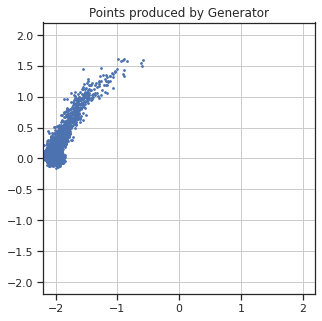

In [117]:
zs = proposal.sample((5000,))
xs_normalized = G(zs).detach().numpy()
xs = xs_normalized #scaler.inverse_transform(xs_normalized)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.scatter(xs[:, 0], xs[:, 1], s=3)
ax.set_aspect('equal')
plt.xlim(-2.2, 2.2)
plt.ylim(-2.2, 2.2)
plt.grid()
plt.title('Points produced by Generator')
plt.savefig(Path('../figs/2d_grid', 'gen.png'))